# Visulaising motion capture data

This notebook contains the functions and code for visualising motion capture data obtained from the Qualisys Track Manager Motion Capture system. It will work with .mat files of the data.

### Required modules from python

In [1]:
import numpy as np #numpy for arrays

import numpy.ma as ma #to mask nans (gaps in the data)

import matplotlib.pyplot as plt #for plotting
from mpl_toolkits import mplot3d #for 3d plots

import seaborn as sns #for prettier plots
sns.set_style('darkgrid') #darkgrid for easier readability of plots


The following is a function to properly convert matlab .mat strictures into python dictionaries. This is used instead of the scipy module for reading .mat structures as the scipy module does not completely unfold the substructures in the .mat file in an accessible form.
NB: This code is not mine it was suggested on stack overflow

In [2]:
#stack overflow, thank youuuuu
#An altered function to read matlab structures on python and recast them into proper dictionaries
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Loading a data file: An example

In [3]:
#testing the loadmat function
test_mat = loadmat('/Users/lakshmipriyaswaminathan/Downloads/PILOT_S6_M6_MC10_TREADMILL_14_04_2020 - Copy.mat')



In [4]:
#listing all the keys in the dictionary.
Keys = list(test_mat.keys())



In [5]:
#Accessing the actual data
test_mat['PILOT_S6_M6_MC10_TREADMILL_14_04_2020']['Trajectories']['Labeled'].keys()

dict_keys(['Count', 'Labels', 'Data', 'Type'])

In [6]:
test_mat[Keys[3]].keys()

dict_keys(['File', 'Timestamp', 'StartFrame', 'Frames', 'FrameRate', 'Trajectories'])

In [7]:
#now let's start saving trajectories etc
markertrajectories = test_mat['PILOT_S6_M6_MC10_TREADMILL_14_04_2020']['Trajectories']['Labeled']['Data']

## Accessing the data from the matlab files

The next few cells contain functions that can be used to access different aspects of the data from the matlab 
structures. 

In [92]:
def access_data(mat_dictionary,type_data='trajectories',trajectories_masked=False):
    """A function to access the labeled trajectory data in the matlab structure after it
    has been converted into a python dicitonary"""
    
    #first we obtain the keys of the dictionary. 
    #Due to the way in which QTM saves it's files, the fourth key (index 3) contains the data.
    
    keys = list(mat_dictionary.keys())
    
    if type_data == 'trajectories': #to access 3d trajectory data
        trajectories = mat_dictionary[keys[3]]['Trajectories']['Labeled']['Data']
        if trajectories_masked == True:
            trajectories = np.ma.masked_invalid(trajectories)
            #print('Masking trajectories')
        else:
            trajectories=trajectories
        #print('Getting the trajectories!')
        return trajectories
    
    elif type_data == 'labels': #to access label names
        labels = mat_dictionary[keys[3]]['Trajectories']['Labeled']['Labels']
        #print('Getting the marker labels!')
        return labels
        
    elif type_data == 'frames':
        frames = mat_dictionary[keys[3]]['Frames']
        frame_rate = mat_dictionary[keys[3]]['FrameRate']
        #print('Getting the frames and frame rate (in that order)!')
        return frames, frame_rate
    
    elif type_data == 'everything':
        frames = mat_dictionary[keys[3]]['Frames']
        frame_rate = mat_dictionary[keys[3]]['FrameRate']
        labels = mat_dictionary[keys[3]]['Trajectories']['Labeled']['Labels']
        trajectories = mat_dictionary[keys[3]]['Trajectories']['Labeled']['Data']
        #print('Getting the: 0. frames, 1. frame rate, 2. labels, and 3. trajectories!')
        return frames, frame_rate, labels, trajectories
    else:
        raise ValueError('I can only access frames, frame rate, labels and trajectories')
    
        
        


In [93]:
#creating a label array
labels = access_data(test_mat, type_data='labels')

In [94]:
#Viewing the labels
labels

array(['Coordinate_right', 'Hip_left', 'Hip_right', 'Knee_right',
       'Ankle_right', 'Back_left', 'Back_right', 'Knee_left',
       'Coordinate_left', 'Ankle_left'], dtype=object)

In [95]:
#creating an array of masked trajectories
maskedmarkertrajectories = access_data(test_mat, type_data='trajectories', trajectories_masked=True)

In [96]:
#accessing total number of frames in recording, and framerate
frames, frame_rate = access_data(test_mat, type_data='frames')


In [100]:
# a function to create a time array
def make_time_array(mat_structure): 
    """A function that creates a time array for a given mat structure data file"""
    fs,fps = access_data(mat_structure, type_data='frames')
    #print('Creating time array!')
    #print('Your time array is ready!')
    time = np.linspace(0,fs/fps,int(fs))
    
    return time

In [101]:
#creating a time array
time = make_time_array(test_mat)

We still need a function to access single marker trajectories as well. Let us make one for that.

In [102]:
def single_marker_trajectories(mat_structure, marker_name, masked=False):
    """A function to access single marker trajectories and define them as arrays 
    that can be used in later analysis"""
    
    mls = access_data(mat_structure,type_data='labels') #accessing marker labels
    #now we access the right trajectory
    for i in range(len(mls)):
        #print(mls[i])
        if str(marker_name) == mls[i]:
            #print(mls[i])
            mi = i
            #print(i)
        #else:
         #   return 'Something is wrong with the spelling'
    #we access the trajectories
    marker_traj = access_data(mat_structure,type_data='trajectories',trajectories_masked=True)[mi]
    
    return marker_traj
    

In [103]:
#will implement a work around this step

Coordinate_right = single_marker_trajectories(test_mat, 'Coordinate_right', masked=True)
Hip_left = single_marker_trajectories(test_mat, 'Hip_left', masked=True)
Hip_right = single_marker_trajectories(test_mat, 'Hip_right', masked=True)
Knee_right = single_marker_trajectories(test_mat, 'Knee_right', masked=True)
Ankle_right = single_marker_trajectories(test_mat, 'Ankle_right', masked=True)
Back_left = single_marker_trajectories(test_mat, 'Back_left', masked=True)
Back_right = single_marker_trajectories(test_mat, 'Back_right', masked=True)
Knee_left = single_marker_trajectories(test_mat, 'Knee_left', masked=True)
Coordinate_left = single_marker_trajectories(test_mat, 'Coordinate_left', masked=True)
Ankle_left = single_marker_trajectories(test_mat, 'Ankle_left', masked=True)

# Visualising the data we just accessed

The following cells help us visualise 3d trajectories, their visibility, and the statistics of the gaps in the data

In [104]:
%matplotlib inline

In [105]:
#%matplotlib 
#uncomment line above to make interactive plots like the Matlab figures

In [106]:
labels

array(['Coordinate_right', 'Hip_left', 'Hip_right', 'Knee_right',
       'Ankle_right', 'Back_left', 'Back_right', 'Knee_left',
       'Coordinate_left', 'Ankle_left'], dtype=object)

In [107]:
def plot_single_marker(data_structure, marker_label,plot_type='2D_line'):
    """A function to plot the x,y,z trajectories of a given marker."""
    mls = access_data(data_structure,type_data='labels') #accessing marker labels
    #print(mls)
    #now we access the right trajectory
    for i in range(len(mls)):
        #print(mls[i])
        if str(marker_label) == mls[i]:
            #print(mls[i])
            mi = i
            #print(i)
        #else:
         #   return 'Something is wrong with the spelling'
    #we access the trajectories
    marker_traj = access_data(data_structure,type_data='trajectories',trajectories_masked=True)[mi]
    
    #we make a time array
    ts = make_time_array(data_structure)
    
    #now we plot!
    if plot_type == '2D_line':

        figure_trajectory = plt.figure()
        sns.set_style('darkgrid')
    
    
        plt.plot(ts,marker_traj[0,:],label='$x(t)$')
        plt.plot(ts,marker_traj[1,:],label='$y(t)$')
        plt.plot(ts,marker_traj[2,:],label='$z(t)$')
    
        plt.xlabel('Time in Seconds')
        plt.ylabel('Position in Millimeters')
    
        plt.legend()
    
        plt.title(str(mls[mi]))
        
        
    elif plot_type == '2D_scatter':
        figure_trajectory = plt.figure()
        sns.set_style('darkgrid')
    
    
        plt.scatter(ts,marker_traj[0,:],label='$x(t)$')
        plt.scatter(ts,marker_traj[1,:],label='$y(t)$')
        plt.scatetr(ts,marker_traj[2,:],label='$z(t)$')
    
        plt.xlabel('Time in Seconds')
        plt.ylabel('Position in Millimeters')
    
        plt.legend()
    
        plt.title(str(mls[mi]))
    
    elif plot_type == '3D_line':
        figure_trajectory = plt.figure()
        ax = plt.axes(projection='3d')

        ax.plot3D(marker_traj[0,:],marker_traj[1,:],marker_traj[2,:])
        plt.title(str(mls[mi]))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
    elif plot_type == '3D_scatter':
        figure_trajectory = plt.figure()
        ax = plt.axes(projection='3d')

        ax.scatter(marker_traj[0,:],marker_traj[1,:],marker_traj[2,:])
        plt.title(str(mls[mi]))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
    else:
        raise ValueError('I can only plot 2D_line, 2D_scatter, 3D_line and 3D_scatter plots for now. Do not forget to put these arguments in quotes as strings')
        
        

        
    
    return figure_trajectory
    
    
    

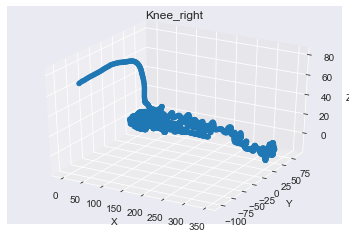

In [108]:
test_fig = plot_single_marker(test_mat,'Knee_right',plot_type='3D_scatter')

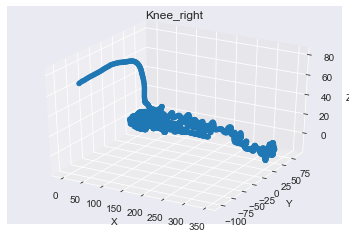

In [109]:
test_fig

In [110]:
%matplotlib

Using matplotlib backend: MacOSX


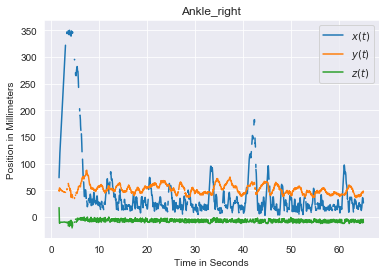

In [111]:
#A 2d plot of the trajectories associated with one marker. 
#Each line corresponds to a certain basis direction as noted in the legend
fig1 = plot_single_marker(test_mat,'Ankle_right')

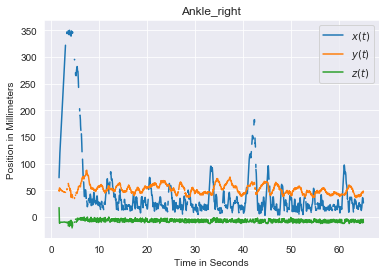

In [112]:
fig1

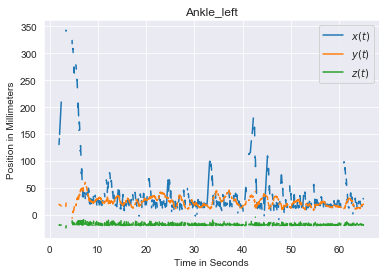

In [113]:
fig2 = plot_single_marker(test_mat,'Ankle_left')

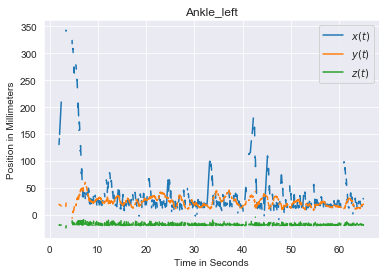

In [114]:
fig2

Now let's write a function for 3D plots

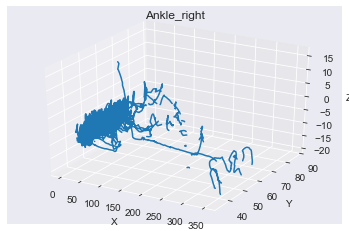

In [115]:
#A 3d plot of one of the marker trajectories (more useful with magic matplotlib command)

fig3 = plot_single_marker(test_mat,'Ankle_right',plot_type='3D_line')


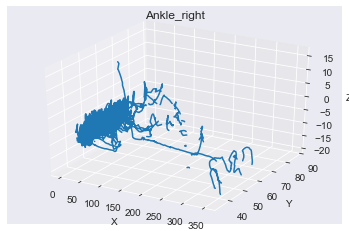

In [116]:
fig3

Now we make functions for plotting multiple markers

In [149]:
def plotting_multiple_markers(mat_structure, marker_names, plot_type='3D_line', multiple_subplots=False,dim='X'):
    """A function to plot multiple marker trajectories. I will probably merge this with the single plot function"""
    num_plots = len(marker_names)  #the number of trajectories that need to be plotted
    mls = access_data(mat_structure,type_data='labels') #accessing marker labels
    #now we access the right trajectory
    traj_t_p = []
    for i in range(len(mls)):
        for j in range(num_plots):
            if str(marker_names[j]) == mls[i]:
            #print(mls[i])
                traj_t_p.append(i)
            #print(i)
        #else:
         #   return 'Something is wrong with the spelling'
    #we access the trajectories
    #print(traj_t_p)
    marker_traj = []
    for k in range(num_plots):
        mi = traj_t_p[k]
        marker_traj.append(access_data(mat_structure,type_data='trajectories',trajectories_masked=True)[mi])
    
    #we make a time array
    ts = make_time_array(mat_structure)
    
    #we make a dimension lable array as well
    dim_s = ['X(t)','Y(t)','Z(t)']
    
    
    #now the plotting part
    
    
    if multiple_subplots == False:
        
        if plot_type == '3D_line':
            fig_trajs = plt.figure()
            sns.set_style('darkgrid')
            ax = plt.axes(projection='3d')
            for l in range(num_plots):
                ax.plot3D((marker_traj[l])[0,:],(marker_traj[l])[1,:],(marker_traj[l])[2,:], label=str(mls[traj_t_p[l]]))
            ax.set_xlabel('X(mm)',fontweight='bold')
            ax.set_ylabel('Y(mm)',fontweight='bold')
            ax.set_zlabel('Z(mm)',fontweight='bold')
            ax.legend()
        
        
        
        
        elif plot_type == '3D_scatter':
            fig_trajs = plt.figure()
            sns.set_style('darkgrid')
            ax = plt.axes(projection='3d')
            for l in range(num_plots):
                ax.scatter((marker_traj[l])[0,:],(marker_traj[l])[1,:],(marker_traj[l])[2,:], label=str(mls[traj_t_p[l]]))
            ax.set_xlabel('X(mm)',fontweight='bold')
            ax.set_ylabel('Y(mm)',fontweight='bold')
            ax.set_zlabel('Z(mm)',fontweight='bold')
            ax.legend()
        
        
        
        elif plot_type == '2D_line':
            fig_trajs = plt.figure()
            sns.set_style('darkgrid')
            plt.xlabel('Time in seconds')
            plt.ylabel('Position in mm')
            for l in range(num_plots):
                for m in range(3):
                    plt.plot(time,marker_traj[l][m,:],label= marker_names[l]+' '+dim_s[m])
            plt.legend()
            
            
        elif plot_type == '2D_scatter':
            fig_trajs = plt.figure()
            sns.set_style('darkgrid')
            plt.xlabel('Time in seconds')
            plt.ylabel('Position in mm')
            for l in range(num_plots):
                for m in range(3):
                    plt.scatter(time,marker_traj[l][m,:],label=marker_names[l]+' '+dim_s[m])
            plt.legend()
            
            
                    
    else:
  
        
        if plot_type == '3D_line':
            
            for l in range(num_plots):
                fig_trajs = plt.figure()
                sns.set_style('darkgrid')
                ax = fig_trajs.add_subplot(num_plots//2,2,l+1,projection='3d')
                ax.plot3D((marker_traj[l])[0,:],(marker_traj[l])[1,:],(marker_traj[l])[2,:], label=str(mls[traj_t_p[l]]))
                ax.set_xlabel('X(mm)',fontweight='bold')
                ax.set_ylabel('Y(mm)',fontweight='bold')
                ax.set_zlabel('Z(mm)',fontweight='bold')
                ax.legend()
        
            
            
        elif plot_type == '3D_scatter':
            
            for l in range(num_plots):
                fig_trajs = plt.figure()
                sns.set_style('darkgrid')
                ax = fig_trajs.add_subplot(num_plots//2,2,l+1,projection='3d')
                ax.plot3D((marker_traj[l])[0,:],(marker_traj[l])[1,:],(marker_traj[l])[2,:], label=str(mls[traj_t_p[l]]))
                ax.set_xlabel('X(mm)',fontweight='bold')
                ax.set_ylabel('Y(mm)',fontweight='bold')
                ax.set_zlabel('Z(mm)',fontweight='bold')
                ax.legend()
        
        
        elif plot_type == '2D_line':
            fig_trajs = plt.figure()
            sns.set_style('darkgrid')
            plt.xlabel('Time in seconds')
            plt.ylabel('Position in mm')
            for l in range(num_plots):
                plt.subplot(num_plots//2,2,l+1)
                for m in range(3):
                    plt.plot(time,marker_traj[l][m,:],label= marker_names[l]+' '+dim_s[m])
                plt.legend()
        
        
        elif plot_type == '2D_scatter':
            fig_trajs = plt.figure()
            sns.set_style('darkgrid')
            plt.xlabel('Time in seconds')
            plt.ylabel('Position in mm')
            for l in range(num_plots):
                plt.subplot(num_plots//2,2,l+1)
                for m in range(3):
                    plt.scatter(time,marker_traj[l][m,:],label= marker_names[l]+' '+dim_s[m])
                plt.legend()
                
        elif plot_type == '2D_single_dim_st':
            fig_trajs = plt.figure()
            sns.set_style('darkgrid')
            plt.xlabel('Time in seconds')
            plt.ylabel('Position in mm')
            for l in range(num_plots):
                plt.subplot(num_plots//2,2,l+1)
                if dim == 'X':
                    plt.scatter(time,marker_traj[l][0,:],label= marker_names[l]+' '+dim_s[0])
                elif dim == 'Y':
                    plt.scatter(time,marker_traj[l][1,:],label= marker_names[l]+' '+dim_s[1])
                elif dim == 'Z':
                    plt.scatter(time,marker_traj[l][2,:],label= marker_names[l]+' '+dim_s[2])
                else:
                    raise ValueError('Given input for dim does not match X,Y or Z!')
                plt.legend()
        elif plot_type == '2D_single_dim_ln':
            fig_trajs = plt.figure()
            sns.set_style('darkgrid')
            plt.xlabel('Time in seconds')
            plt.ylabel('Position in mm')
            for l in range(num_plots):
                plt.subplot(num_plots//2,2,l+1)
                if dim == 'X':
                    plt.plot(time,marker_traj[l][0,:],label= marker_names[l]+' '+dim_s[0])
                elif dim == 'Y':
                    plt.plot(time,marker_traj[l][1,:],label= marker_names[l]+' '+dim_s[1])
                elif dim == 'Z':
                    plt.plot(time,marker_traj[l][2,:],label= marker_names[l]+' '+dim_s[2])
                else:
                    raise ValueError('Given input for dim does not match X,Y or Z!')
                plt.legend()
        else:
            raise ValueError('Given input for plot_type does not match 2D_line, 2D_scatter, 3D_line, 3D_scatter, 2D_single_dim_st, 2D_single_dim_ln')
            
            
            
        
    
    
    return fig_trajs
   
        
    

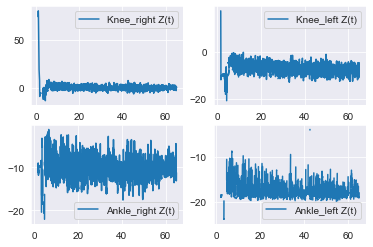

In [150]:
test_mult = plotting_multiple_markers(test_mat,['Knee_right','Knee_left','Ankle_right','Ankle_left'],plot_type='2D_single_dim_ln',multiple_subplots=True, dim='Z')

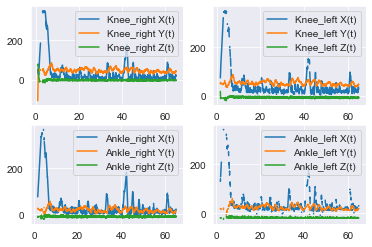

In [143]:
test_mult

<Figure size 432x288 with 0 Axes>

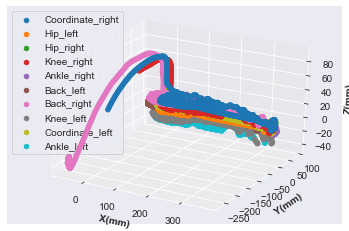

In [140]:

fig4 = plt.figure(4)
sns.set_style('dark')

#ax = plt.axes(projection='3d')


#plotting all off them
all_markers  = plotting_multiple_markers(test_mat,labels,plot_type='3D_scatter')

# ax.set_xlabel('X(mm)',fontweight='bold')
# ax.set_ylabel('Y(mm)',fontweight='bold')
# ax.set_zlabel('Z(mm)',fontweight='bold')


# ax.set_xlim3d(0, 300)
# ax.set_ylim3d(5,85)
# ax.set_zlim3d(-20,30)

#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])

plt.show()

#plt.savefig('3dtrajectories.png',transparent=True)

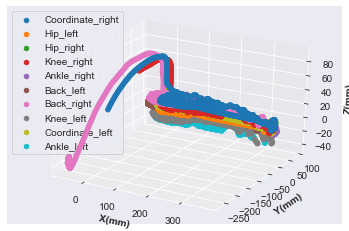

In [141]:
all_markers

In [ ]:
# I need to merge the plotting functions, so that we can have single dimensions, subplots etc.
#Let's start with subplot functionality, simple is a column of plots

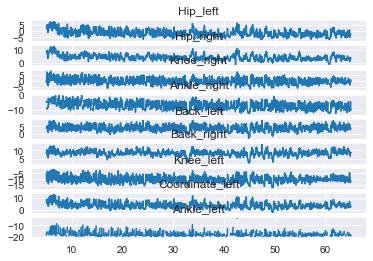

In [54]:
#A plot of just the z dimension
fig5 = plt.figure(5)

sns.set_style('darkgrid')

for i in np.array([1,2,3,4,5,6,7,8,9]):

    plt.subplot(9,1,i)
    plt.plot(time[1500:],maskedmarkertrajectories[i,2,1500:])
    plt.title(str(labels[i]))
    
    
plt.show()

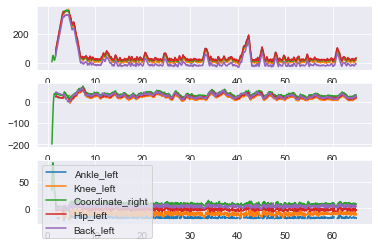

In [56]:
#plot of all markers on one side, all three dimensions
fig13 = plt.figure(13)
sns.set_style('darkgrid')
plt.subplot(3,1,1)
plt.plot(time,maskedmarkertrajectories[9,0,:],label=str(labels[9]))
plt.plot(time,maskedmarkertrajectories[7,0,:],label=str(labels[7]))
plt.plot(time,maskedmarkertrajectories[0,0,:],label=str(labels[0]))
plt.plot(time,maskedmarkertrajectories[1,0,:],label=str(labels[1]))
plt.plot(time,maskedmarkertrajectories[5,0,:],label=str(labels[5]))



plt.subplot(3,1,2)
plt.plot(time,maskedmarkertrajectories[9,1,:],label=str(labels[9]))
plt.plot(time,maskedmarkertrajectories[7,1,:],label=str(labels[7]))
plt.plot(time,maskedmarkertrajectories[0,1,:],label=str(labels[0]))
plt.plot(time,maskedmarkertrajectories[1,1,:],label=str(labels[1]))
plt.plot(time,maskedmarkertrajectories[5,1,:],label=str(labels[5]))

plt.subplot(3,1,3)
plt.plot(time,maskedmarkertrajectories[9,2,:],label=str(labels[9]))
plt.plot(time,maskedmarkertrajectories[7,2,:],label=str(labels[7]))
plt.plot(time,maskedmarkertrajectories[0,2,:],label=str(labels[0]))
plt.plot(time,maskedmarkertrajectories[1,2,:],label=str(labels[1]))
plt.plot(time,maskedmarkertrajectories[5,2,:],label=str(labels[5]))

plt.legend()

plt.show()

In [33]:
#now let's work on vibility
left_hip_uma = markertrajectories[0,:3,:]
np.shape(left_hip_uma)

(3, 19500)

In [34]:
def visibility(mtraj,boolean=False):
    
        
    vm = np.invert(np.isnan(mtraj)) #this inverts the trajectory to make all Nan's equal to zero
    #now I have to multiply along xyz
    if len(np.shape(mtraj)) <3:
        vm_red = np.prod(vm,axis=0)
    else:
        vm_red = np.prod(vm,axis=1)
    if boolean==False:
        vm_red_ = ma.masked_where(vm_red==0,vm_red) #to get masked values for Nan's
        return vm_red_
    elif boolean==True:
        return vm_red #to get zero for Nans and ones for visible values
    else:
        return ValueError('Can only take value True or False')
    


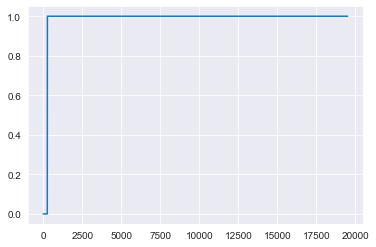

In [35]:
fig3 = plt.figure(3)
plt.plot(visibility(left_hip_uma,boolean=True))
plt.show()

In [36]:
#now let's do this for all the markers like in matlab

In [37]:
np.shape(markertrajectories)

(10, 4, 19500)

In [38]:
allmarkervm = visibility(markertrajectories[:,:3,:])


In [39]:
#%matplotlib

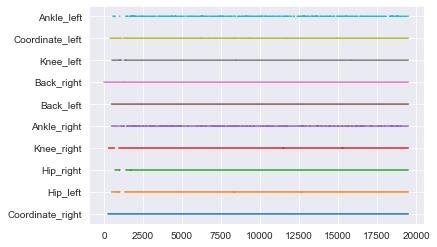

In [40]:
fig4 = plt.figure(4)
for i in range(len(labels)):
    plt.plot(allmarkervm[i]*i)
plt.yticks(np.arange(0,10,1),labels)    
plt.show()

In [41]:
#now some stats on the visibility or can i just ignore gaps? (no let's not!)
test_array = [0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0]
#let us try and get the three different strings of zeros
def zerostrings(iarray):
    iarray = np.array(iarray)
    iarray = iarray.astype(int)
    idx = []
    if iarray[0] == 0:
        idx.append(0)
    for i in range(len(iarray)-1):
        if iarray[i]+iarray[i+1] == 1: #this is the changing point
            if iarray[i] == 0:
                idx.append(i)
            else:
                idx.append(i+1)
                
    if iarray[-1] == 0:
        idx.append(len(iarray))
    #the part where we count lengths, ok so we group every two indices
    zslens = []
    itc = []
    for i in range(len(idx)):
        if i%2==0:
            itc.append(i)
    for i in itc:
        if idx[i]==0:
            zslens.append(idx[i+1]-idx[i]+1)
        elif int(idx[i+1]-idx[i]) == 1:
            zslens.append(2)
        else:
            zslens.append(idx[i+1]-idx[i])
    lidx = len(idx)
    #test
    if len(zslens) == lidx//2:
        
        idx_pairs = np.reshape(idx,(lidx//2,2))
        output = []
        for i in range(len(zslens)):
            output.append((idx_pairs[i],zslens[i]))
        
        return np.array(output)
    else:
        return ValueError('dimensions do not match')
            

In [42]:
test_zs = zerostrings(test_array) #it works! 0.o
#ofcourse this is just for single arrays, now I have to make a modified one for all the markers

In [43]:
np.shape(test_zs)

(3, 2)

In [44]:
zs_t =zerostrings(visibility(markertrajectories[1,:3,:],boolean=True))

In [45]:
zs_t

array([[array([  0, 493]), 494],
       [array([929, 961]), 32],
       [array([1030, 1343]), 313],
       [array([1366, 1404]), 38],
       [array([8344, 8357]), 13],
       [array([12659, 12685]), 26]], dtype=object)

In [46]:
labels

array(['Coordinate_right', 'Hip_left', 'Hip_right', 'Knee_right',
       'Ankle_right', 'Back_left', 'Back_right', 'Knee_left',
       'Coordinate_left', 'Ankle_left'], dtype=object)

In [47]:
left_hip_uma = markertrajectories[1,:3,:]
left_hip_ma = maskedmarkertrajectories[1,:3,:]

In [48]:
right_hip_uma = markertrajectories[2,:3,:]

In [49]:
#I know how to get the gaps now let's visualise the statistics of the gaps!
#a function to plot some sort of distribution of the gaps:
#the input will the zero string lengths, i.e. the second part of the zero string code
def gapstats(markertraj):
    #first we compute the zero strings
    markervisibility = visibility(markertraj, boolean=True)
    markergaps_ind_len = zerostrings(markervisibility)
    # I have both of them... now I can plot both the visibility and the gap stats:
    #gapstats part
    markergaps_len = markergaps_ind_len[:,1]
    bin_edges=[1,3,30,300,3000] #this is in terms of frames
    hist_gaps, bin_gaps = np.histogram(markergaps_len,bins =bin_edges)
    bin_gaps_second = [1,2,3,4]
    return hist_gaps, bin_gaps_second
    

In [50]:
a_test, b_test = gapstats(markertrajectories[4,:2,:])

In [51]:
a_test

array([  1, 104,  19,   1])

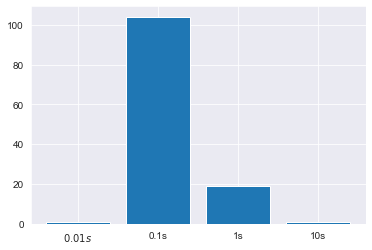

In [52]:
fig11 = plt.figure(11)
plt.bar(b_test, a_test)
#plt.xscale('log')
#plt.yscale('log')
plt.xticks(range(len(a_test)+1)[1:],('$0.01s$','0.1s','1s','10s'))

plt.show()

In [53]:
#filling gaps


In [54]:
#so first step, remove the nans in the beginning
def removenans_be(data):
    #casting the 3d data in the right shape
    a,b = np.shape(data)
    if a<b:
        data=data
    else:
        data = np.transpose(data)
    #first we compute the positions of the breaks in the data
    breaks_data = zerostrings(visibility(data,boolean=True))
    #now we get the initial string of zeros
    fb = breaks_data[0] #the first gap
    print((fb))
    if np.shape(breaks_data)[0]>1:
        lb = breaks_data[-1] #the last gap
    
    #now checking that the first break is in the beginning
    if (fb[0])[0] == 0:
        #now we cut out this part
        fcf,fce = (fb[0])
        nan_cutdata = data[:,fce+1:]
    else:
        nan_cutdata = data #in case the first gap isn't in the begininng
    #next the ending part:
    if np.shape(breaks_data)[0]>1:
        lcf, lce = (lb[0])
        nan_cutdata = nan_cutdata[:,:lcf]
    return nan_cutdata
        
        
    

In [55]:
# filling gaps using linear or polynomial fitting, this is done after removing Nans at the beginning and end

In [56]:
#so my visibility function can be used to get data about Nan's

In [57]:
right_ankle_uma = markertrajectories[9,:3,1500:]

In [58]:
nan_cutright_ankle = removenans_be(right_ankle_uma)

[array([ 36, 129]) 93]


In [59]:
empty_trial = np.empty(np.shape(maskedmarkertrajectories[0,:3,:]))

In [60]:
(zerostrings(visibility(nan_cutright_ankle)))

array([[array([ 36, 129]), 93],
       [array([157, 195]), 38],
       [array([226, 247]), 21],
       [array([272, 278]), 6],
       [array([303, 316]), 13],
       [array([320, 339]), 19],
       [array([374, 397]), 23],
       [array([405, 416]), 11],
       [array([447, 466]), 19],
       [array([520, 542]), 22],
       [array([607, 680]), 73],
       [array([718, 789]), 71],
       [array([833, 871]), 38],
       [array([947, 968]), 21],
       [array([1023, 1083]), 60],
       [array([1113, 1183]), 70],
       [array([1190, 1216]), 26],
       [array([1237, 1318]), 81],
       [array([1349, 1396]), 47],
       [array([1432, 1500]), 68],
       [array([1528, 1576]), 48],
       [array([1622, 1665]), 43],
       [array([1706, 1762]), 56],
       [array([1801, 1904]), 103],
       [array([1933, 2017]), 84],
       [array([2055, 2079]), 24],
       [array([2157, 2218]), 61],
       [array([2269, 2324]), 55],
       [array([2365, 2409]), 44],
       [array([2451, 2513]), 62],
       [

In [61]:
nan_cutright_ankle[:,35:129]

array([[263.26597973,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,     

In [62]:
ra_gaps, ra_x = gapstats(nan_cutright_ankle)

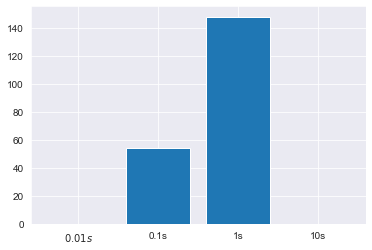

In [63]:
fig12 = plt.figure(12)
plt.bar(ra_x, ra_gaps)
#plt.xscale('log')
#plt.yscale('log')
plt.xticks(range(len(a_test)+1)[1:],('$0.01s$','0.1s','1s','10s'))

plt.show()

In [64]:
#now we have the gaps, anything that's within, 0.1seconds
#that's withing 30 frames, we try and do linear fits
#anything that's within 30-300 frames polynomial higher degree(3?)


In [65]:
test_sec = nan_cutright_ankle[0,216:257]
test_time = time[216:257]

In [66]:
test_gap = time[226:247]
test_time = np.concatenate((test_time[:10],test_time[-9:]))

In [67]:
test_time

array([0.72003692, 0.72337043, 0.72670393, 0.73003744, 0.73337094,
       0.73670445, 0.74003795, 0.74337145, 0.74670496, 0.75003846,
       0.82670906, 0.83004257, 0.83337607, 0.83670957, 0.84004308,
       0.84337658, 0.84671009, 0.85004359, 0.8533771 ])

In [68]:
np.interp(test_gap,test_time,test_sec[~np.isnan(test_sec)])

array([234.52458887, 232.99416873, 231.46374859, 229.93332845,
       228.40290831, 226.87248817, 225.34206802, 223.81164788,
       222.28122774, 220.7508076 , 219.22038746, 217.68996732,
       216.15954718, 214.62912704, 213.0987069 , 211.56828676,
       210.03786662, 208.50744648, 206.97702634, 205.44660619,
       203.91618605])

In [69]:
nan_cutright_ankle[:,214:226]

array([[245.27236083, 244.38503491, 243.48363286, 242.57465089,
        241.6659753 , 240.77265829, 239.89786558, 239.05394574,
        237.99275596, 237.62321718, 236.82734177, 236.05500901],
       [ 29.54477727,  29.68574707,  29.83361669,  29.97591333,
         30.04777626,  30.09916481,  30.17379043,  30.1931731 ,
         29.86835971,  30.56247932,  30.54536561,  30.44210348],
       [-14.69272232, -14.77716215, -14.85478693, -14.8724772 ,
        -14.83811179, -14.75833779, -14.60246059, -14.27833045,
        -13.72692786, -13.61266598, -13.13746442, -12.4759438 ]])

In [70]:
np.shape(test_sec[~np.isnan(test_sec)])
        
    

(19,)

In [71]:
labels

array(['Coordinate_right', 'Hip_left', 'Hip_right', 'Knee_right',
       'Ankle_right', 'Back_left', 'Back_right', 'Knee_left',
       'Coordinate_left', 'Ankle_left'], dtype=object)

In [72]:
right_knee_uma  = markertrajectories[3,:3,:]

In [73]:
nan_cut_right_knee = removenans_be(right_knee_uma)

[array([  0, 290]) 291]


In [74]:
zs_right_knee = zerostrings(visibility(nan_cut_right_knee, boolean=True))

In [75]:
zs_right_knee

array([[array([382, 663]), 281],
       [array([11204, 11215]), 11],
       [array([14994, 14994]), 0]], dtype=object)

In [76]:
#so now we start with the interpolation functions
def movwinfilllin(marker_traj,time,window=10):
    #first we find the zerostrings
    zs  = zerostrings(visibility(marker_traj,boolean=True))
    small_gaps = []
    #the first line finds all gaps that are 10frames
    for i in range(len(zs[:,1])):
        if 0<=zs[i,1] <=30:
            small_gaps.append(zs[i])
    small_gaps = np.array(small_gaps)
    #now we have all the small_gaps
    #we try to fill those in linearly
    #we first pick our window:
    for j in range(len(small_gaps[:,1])):
        t_0 = small_gaps[j,0][0]
        t_t = small_gaps[j,0][1]
        start = t_0-10
        end = t_t +10
        #we use the start and end to define our data window
        window_x = marker_traj[0,start:end]
        window_y = marker_traj[1,start:end]
        window_z = marker_traj[2,start:end]
        
        #removing nans
        window_x = window_x[~np.isnan(window_x)]
        window_y = window_y[~np.isnan(window_y)]
        window_z = window_z[~np.isnan(window_z)]
        time_window = np.concatenate((time[start:t_0],time[t_t+1:end]))
        print(len(time_window),len(window_x))
        time_gap = time[t_0:t_t]
        #interpolate now
        ip_x = np.interp(time_gap,time_window,window_x)
        ip_y = np.interp(time_gap,time_window,window_y)
        ip_z = np.interp(time_gap,time_window,window_z)
        
        #now we have to reattach this into the place
        marker_traj[0,t_0:t_t] = ip_x
        marker_traj[1,t_0:t_t] = ip_y
        marker_traj[2,t_0:t_t] = ip_z
    return marker_traj
           
        
    
    
    
            
    

In [77]:
test_gf = movwinfilllin(nan_cut_right_knee,time)

19 19
19 19


In [78]:
zs_gf_test = zerostrings(visibility(test_gf,boolean=True))


In [79]:
zs_gf_test

array([[array([382, 663]), 281],
       [array([11215, 11215]), 0],
       [array([14994, 14994]), 0]], dtype=object)

In [80]:
np.shape(empty_trial)

(3, 19500)

In [81]:
np.shape(maskedmarkertrajectories)

(10, 4, 19500)

In [82]:
def PCA(timeseries):
    #mean subtract things
    a,b = np.shape(timeseries)
    if a>b:
        N=a
        d=b
        
    else:
        d=a
        N=b
        timeseries = np.transpose(timeseries)
    timeseries_mean0 = np.zeros((N,d))
    for i in range(d):
        timeseries_mean0[:,i] = timeseries[:,i] - np.nanmean(timeseries[:,i])
        
    #now after mean subtraction we get the covariance matrix of stuff
    covT = np.ma.cov(np.transpose(timeseries_mean0))
    
    #finally PCA part
    PCs,PCvecs = np.linalg.eig(covT)
    #normalising the PCs
    
    normPCs = PCs/sum(PCs)
    sortedpcs = (np.sort(normPCs))[::-1]
    
    return sortedpcs, PCvecs

In [83]:
trajectories_reshaped = np.reshape(maskedmarkertrajectories[:,:3,:],(30,19500))

In [84]:
trajpcs,trajPCvecs = PCA(trajectories_reshaped)

LinAlgError: Array must not contain infs or NaNs

In [85]:
def acf(data):
    l = len(data)
    data_2 = data[:l//2]
    data_2 = data_2 - ma.mean(data_2)
    acf_data = []
    for i in range(l//2):
        acf_data.append(ma.corrcoef(data_2,data[0+i:(l//2)+i]))
    return acf_data
        

In [86]:
#test_acf_lh_x = acf(left_hip[0,:])
#test_acf_lh_y = acf(left_hip[1,:])
#test_acf_lh_z = acf(left_hip[2,:])

In [87]:
#fig15 = plt.figure(15)
#plt.plot(test_acf_lh_x)
#plt.show()

# Coordinate Transform

In [88]:
a1 = markertrajectories[0,:3,1000:1001]
a2 = markertrajectories[0,:3,1001:1002]

In [89]:
b1 = markertrajectories[1,:3,1000:1001]
b2 = markertrajectories[1,:3,1001:1002]

In [90]:
a = markertrajectories[0,:3,1000:1002]
b = markertrajectories[1,:3,1000:1002]

In [91]:
(a1 + b1)/2

array([[349.35854468],
       [ 30.61820238],
       [ -2.04032184]])

In [92]:
(a2 + b2)/2

array([[349.31142138],
       [ 30.92004926],
       [ -1.91427521]])

In [93]:
(a+b)/2

array([[349.35854468, 349.31142138],
       [ 30.61820238,  30.92004926],
       [ -2.04032184,  -1.91427521]])

In [94]:
#First we need to define functions to compute midpoints between two markers, more specifically the hips
def midpoint(marker1, marker2):
    a1,b1 = np.shape(marker1)
    a2,b2 = np.shape(marker2)
    #another step to make sure that both timeseries have the same length
    if b2!=b1:
        if b2>b1:
            marker2 = marker2[:,:b1]
            dl = b1
        elif b1>b2:
            marker1 = marker1[:,:b2]
            dl = b2
        
    
    if a1>b1:
        marker1 = np.transpose(marker1)
    if a2>b2:
        marker2 = np.transpose(marker2)
    if a2!=a1:
        raise ValueError('Dimensions don\'t match!')
    
        
    #now we define a dummy array for the mid point
    midpoint_array = (marker1+marker2)/2
    midpoint_array_masked = ma.masked_invalid(midpoint_array)
    return midpoint_array_masked
    
 

In [95]:
test_mp = midpoint(maskedmarkertrajectories[0,:3,:],maskedmarkertrajectories[1,:3,:])

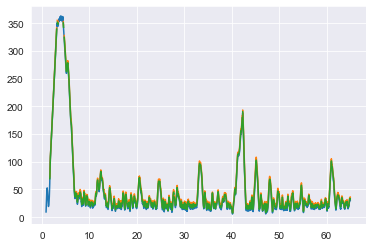

In [96]:
fig16 = plt.figure(16)

plt.plot(time,maskedmarkertrajectories[0,0,:])
plt.plot(time,maskedmarkertrajectories[1,0,:])
plt.plot(time,test_mp[0,:])

plt.show()

In [97]:
#Midpoint works! now I definie my vectors!

In [98]:
a = [1,1]
b = [2,2]
c = [3,3]
np.transpose(np.vstack((a,b,c)))

array([[1, 2, 3],
       [1, 2, 3]])

In [99]:
#now I define the vectors!
def basisvectors(m1,m2,m3,m4):
    #the idea is as follows: we define two vectors on the mouse body using the markers we already have
    #we need three markers to define this, the third vector we pick in such a way 
    #that the third makes them a set of linearly independent vectors,
    #we can now use these as our transformation matrix and transform all the other trajectory point suing that
    
    #easy part defining the two vectors
    #m1,m2,m3,m4 = coord_system #extracting the 3 markers from the array
    
    midpoint1 = (m1+m2)/2 #the two hip markers
    midpoint2 = (m3+m4)/2 #the two back markers
    
    #now we define the directional vector between these two midpoints, the other vector is between the hip markers
    hh = m1 - m2
    hb = midpoint2 - midpoint1
    #that gives us two vectors out of the 3
    #now we compute the cross product, and the right hand rule will help! m1 should be the right hip :)
    hu = np.cross(hh,hb)
    #we normalise each vector!!
    hh_norm = hh/np.linalg.norm(hh)
    hb_norm = hb/np.linalg.norm(hb)
    hu_norm = hu/np.linalg.norm(hu)
    
    #finally we combine the 3 vectors two get our basis set
    basis_set = np.transpose(np.vstack((hh_norm,hb_norm,hu_norm)))
    return basis_set
    #we have to loop over this somehow...
    

In [100]:
def basisvectors_time(m1,m2,m3,m4):
    #each of the marker trajectories has to be 3xN
    #we check this
    a1,b1 = np.shape(m1)
    a2,b2 = np.shape(m2)
    a3,b3 = np.shape(m3)
    a4,b4 = np.shape(m4)
    if a1>b1:
        m1 = np.transpose(m1)
        N = a1
    elif a1<b1:
        N = b1
    if a2>b2:
        m2 = np.transpose(m2)
    if a3>b3:
        m3 = np.transpose(m3)
    if a4>b4:
        m4 = np.transpose(m4)
    # now we loop over N
    T_matrix = []
    for i in range(N):
        T_matrix.append(basisvectors(m1[:,i],m2[:,i],m3[:,i],m4[:,i]))
    return np.array(T_matrix)

In [101]:
#now I need to find the transformation matrix
#since we have by default that the coordinate system uses the canonical basis set
#our matrix of the basis set is the transformation matrix!
#now the actual coordinate transformation part..we left multiply each position with the basis set

In [102]:
def coordinate_transform(tmatrix,trajectory):
    #the trajectory is a 1,3,N shaped array, so we loop over N
    #the tmatrix is 3*3,N, each column an animal centric basis vector
    a,b = np.shape(trajectory)
    if a>b:
        trajectory = np.transpose(trajectory)
        d = b
        a = N
    elif b>a:
        d = a
        N = b
    #now we loop over N
    coord_trans_traj = []
    for i in range(N):
        coord_trans_traj.append(np.matmul(tmatrix[i,:,:],trajectory[:,i]))
    return np.transpose(coord_trans_traj)


        

In [103]:
tmatrix_test = np.array([[1,2,3],[4,5,7],[8,9,-1]])

In [104]:
np.matmul(tmatrix_test,[1,0,0])

array([1, 4, 8])

In [105]:
np.shape(left_hip)

(3, 19500)

In [106]:
np.shape(markertrajectories)

(10, 4, 19500)

In [107]:
labels

array(['Coordinate_right', 'Hip_left', 'Hip_right', 'Knee_right',
       'Ankle_right', 'Back_left', 'Back_right', 'Knee_left',
       'Coordinate_left', 'Ankle_left'], dtype=object)

In [108]:
right_hip = markertrajectories[2,:3,:]
np.shape(right_hip)

(3, 19500)

In [109]:
left_hip = markertrajectories[1,:3,:]
np.shape(left_hip)

(3, 19500)

In [110]:
right_back = markertrajectories[6,:3,:]
np.shape(right_back)

(3, 19500)

In [111]:
left_back = markertrajectories[5,:3,:]
np.shape(left_back)

(3, 19500)

In [112]:
test_T_matrix = basisvectors_time(right_hip,left_hip,right_back,left_back)

In [113]:
test_T_matrix_2 = basisvectors_time(left_hip,right_hip,left_back,right_back)

In [114]:
test_T_matrix_3 = basisvectors_time(right_hip,left_hip,right_back,left_back)

In [115]:
test_Coord_transform_2 = coordinate_transform(test_T_matrix_2,left_hip)

In [116]:
test_Coord_transform = coordinate_transform(test_T_matrix,left_hip)

In [117]:
np.shape(test_Coord_transform)

(3, 19500)

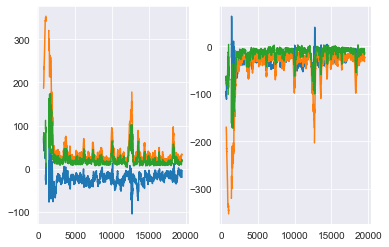

In [118]:
fig15 = plt.figure(15)
plt.subplot(1,2,1)
plt.plot(test_Coord_transform[0,:])
plt.plot(test_Coord_transform[1,:])
plt.plot(test_Coord_transform[2,:])

plt.subplot(1,2,2)
plt.plot(test_Coord_transform_2[0,:])
plt.plot(test_Coord_transform_2[1,:])
plt.plot(test_Coord_transform_2[2,:])

plt.show(fig15)

In [119]:
np.shape(nan_cut_right_knee)

(3, 15285)

In [120]:
#it works!!!

In [121]:
from mpl_toolkits import mplot3d

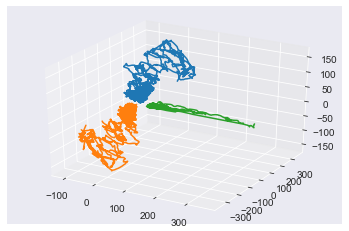

In [122]:
fig28 = plt.figure(28)


ax = plt.axes(projection='3d')



ax.plot3D(test_Coord_transform[0,:],test_Coord_transform[1,:],test_Coord_transform[2,:])
ax.plot3D(test_Coord_transform_2[0,:],test_Coord_transform_2[1,:],test_Coord_transform_2[2,:])
ax.plot3D(left_hip[0,:],left_hip[1,:],left_hip[2,:])

#plt.show()

In [123]:
right_knee = markertrajectories[8,:3,:]

In [124]:
test_right_knee = coordinate_transform(test_T_matrix,nan_cut_right_knee)

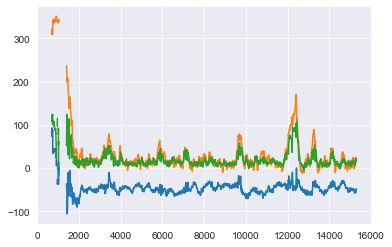

In [125]:
fig16 = plt.figure(16)
plt.plot(test_right_knee[0,:])
plt.plot(test_right_knee[1,:])
plt.plot(test_right_knee[2,:])
plt.show(fig16)

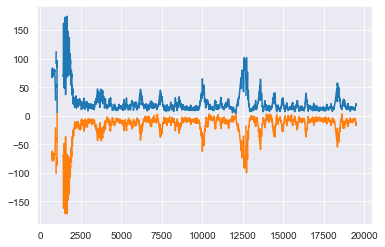

In [126]:
fig17 = plt.figure(17)
plt.plot(test_Coord_transform[2,:])
plt.plot(test_Coord_transform_2[2,:])
#plt.plot(test_Coord_transform[2,:])
plt.show(fig15)

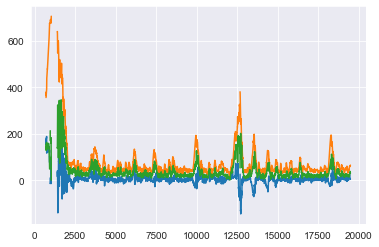

In [127]:
fig18 = plt.figure(18)
plt.plot((test_Coord_transform[0,:] - test_Coord_transform_2[0,:]))
plt.plot((test_Coord_transform[1,:] - test_Coord_transform_2[1,:]))
plt.plot((test_Coord_transform[2,:] - test_Coord_transform_2[2,:]))
plt.show(fig18)

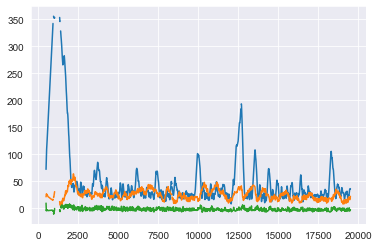

In [128]:
fig19 = plt.figure(19)
plt.plot(left_hip[0,:])
plt.plot(left_hip[1,:])
plt.plot(left_hip[2,:])
plt.show(fig16)

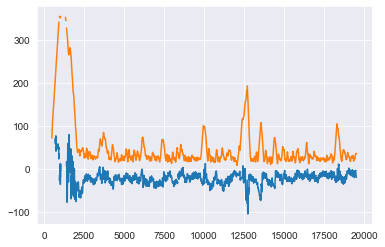

In [129]:
fig20 = plt.figure(20)

plt.plot(test_Coord_transform[0,:])
plt.plot(left_hip[0,:])

plt.show(fig20)

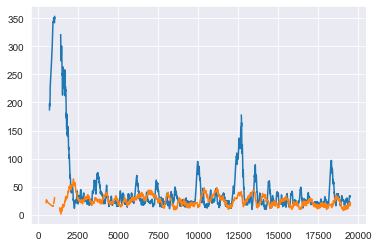

In [130]:
fig21 = plt.figure(21)

plt.plot(test_Coord_transform[1,:])
plt.plot(left_hip[1,:])

plt.show(fig21)

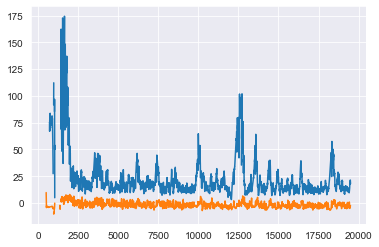

In [131]:
fig22 = plt.figure(22)

plt.plot(test_Coord_transform[2,:])
plt.plot(left_hip[2,:])

plt.show(fig22)

In [132]:
#Now we transform every marker
left_hip_ct = coordinate_transform(test_T_matrix_3,left_hip)

In [133]:
labels


array(['Coordinate_right', 'Hip_left', 'Hip_right', 'Knee_right',
       'Ankle_right', 'Back_left', 'Back_right', 'Knee_left',
       'Coordinate_left', 'Ankle_left'], dtype=object)

In [134]:
right_hip_ct = coordinate_transform(test_T_matrix_3, right_hip)

In [135]:
left_back_ct = coordinate_transform(test_T_matrix_3, left_back)

In [136]:
right_back_ct = coordinate_transform(test_T_matrix_3, right_back)

In [137]:
left_knee = maskedmarkertrajectories[7,:3,:]

In [138]:
left_knee_ct = coordinate_transform(test_T_matrix_3, left_knee)

In [139]:
left_ankle = maskedmarkertrajectories[9,:3,:]

In [140]:
left_ankle_ct = coordinate_transform(test_T_matrix_3, left_ankle)

In [141]:
right_knee = maskedmarkertrajectories[4,:3,:]

In [142]:
right_knee_ct = coordinate_transform(test_T_matrix_3, right_knee)

In [143]:
right_ankle = maskedmarkertrajectories[4,:3,:]

In [144]:
right_ankle_ct = coordinate_transform(test_T_matrix_3, right_ankle)

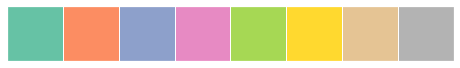

In [145]:
sns.set()
sns.color_palette('Set2')
colour = sns.color_palette('Set2')
sns.palplot(sns.color_palette('Set2'))

In [146]:
#%matplotlib

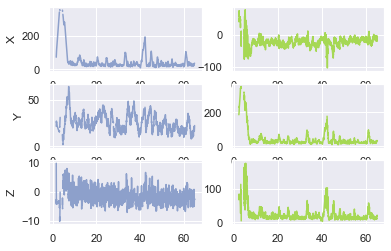

In [147]:
#let's make figures comparing the two
fig23 = plt.figure(23)

plt.subplot(3,2,1)
plt.plot(time,left_hip[0],color=colour[2])
plt.ylabel('X')

plt.subplot(3,2,2)
plt.plot(time, left_hip_ct[0],color=colour[4])


plt.subplot(3,2,3)
plt.plot(time, left_hip[1],color=colour[2])
plt.ylabel('Y')

plt.subplot(3,2,4)
plt.plot(time, left_hip_ct[1],color=colour[4])


plt.subplot(3,2,5)
plt.plot(time, left_hip[2],color=colour[2])
plt.ylabel('Z')

plt.subplot(3,2,6)
plt.plot(time,left_hip_ct[2],color=colour[4])




plt.show(fig23)

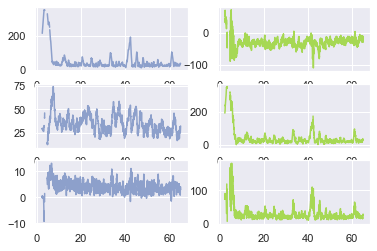

In [148]:
fig24 = plt.figure(24)

plt.subplot(3,2,1)
plt.plot(time,right_hip[0],color=colour[2])

plt.subplot(3,2,2)
plt.plot(time, right_hip_ct[0],color=colour[4])

plt.subplot(3,2,3)
plt.plot(time, right_hip[1],color=colour[2])

plt.subplot(3,2,4)
plt.plot(time, right_hip_ct[1],color=colour[4])

plt.subplot(3,2,5)
plt.plot(time, right_hip[2],color=colour[2])

plt.subplot(3,2,6)
plt.plot(time,right_hip_ct[2],color=colour[4])

plt.show(fig23)

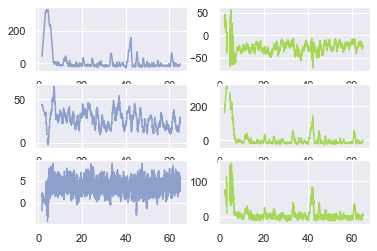

In [149]:
#let's make figures comparing the two
fig25 = plt.figure(25)

plt.subplot(3,2,1)
plt.plot(time,left_back[0],color=colour[2])

plt.subplot(3,2,2)
plt.plot(time, left_back_ct[0],color=colour[4])

plt.subplot(3,2,3)
plt.plot(time, left_back[1],color=colour[2])

plt.subplot(3,2,4)
plt.plot(time, left_back_ct[1],color=colour[4])

plt.subplot(3,2,5)
plt.plot(time, left_back[2],color=colour[2])

plt.subplot(3,2,6)
plt.plot(time,left_back_ct[2],color=colour[4])

plt.show(fig25)

In [150]:
#removing nans from the transformed data
lh_ct_nr = removenans_be(left_hip_ct)

[array([  0, 706]) 707]


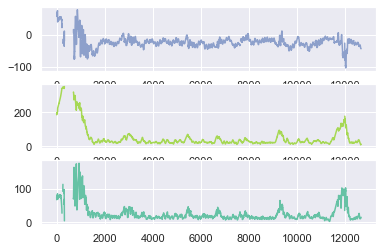

In [151]:
fig26 = plt.figure(26)

plt.subplot(3,1,1)
plt.plot(lh_ct_nr[0],color=colour[2])

plt.subplot(3,1,2)
plt.plot(lh_ct_nr[1],color=colour[4])

plt.subplot(3,1,3)
plt.plot(lh_ct_nr[2],color=colour[0])


plt.show(fig26)

In [152]:
#%matplotlib

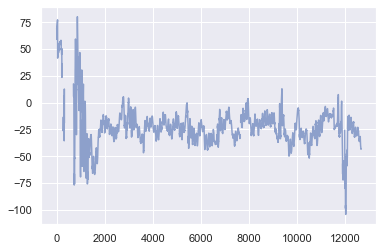

In [153]:
fig27 = plt.figure(27)


plt.plot(lh_ct_nr[0],color=colour[2])
plt.show()

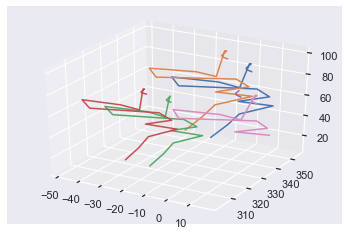

In [154]:
fig29 = plt.figure(29)


ax = plt.axes(projection='3d')



ax.plot3D(left_hip_ct[0,1000:1100],left_hip_ct[1,1000:1100],left_hip_ct[2,1000:1100])
ax.plot3D(right_hip_ct[0,1000:1100],right_hip_ct[1,1000:1100],right_hip_ct[2,1000:1100])
ax.plot3D(left_back_ct[0,1000:1100],left_back_ct[1,1000:1100],left_back_ct[2,1000:1100])
ax.plot3D(right_back_ct[0,1000:1100],right_back_ct[1,1000:1100],right_back_ct[2,1000:1100])
ax.plot3D(left_knee_ct[0,1000:1100],left_knee_ct[1,1000:1100],left_knee_ct[2,1000:1100])
ax.plot3D(right_knee_ct[0,1000:1100],right_knee_ct[1,1000:1100],right_knee_ct[2,1000:1100])
ax.plot3D(left_ankle_ct[0,1000:1100],left_ankle_ct[1,1000:1100],left_ankle_ct[2,1000:1100])
ax.plot3D(right_ankle_ct[0,1000:1100],right_ankle_ct[1,1000:1100],right_ankle_ct[2,1000:1100])

#plt.show()

# Embedding cycles!!

In [155]:
def autocorrelation_function(timeseries,window=False):
    #first we subtract the mean from the timeseries
    timeseries_ms = timeseries - np.mean(timeseries)
    #next we work with the window we're given
    if window==False:
        N = len(timeseries)
        w_ts = timeseries_ms[:N//2]
        W = N//2
    else:
        w_ts = timeseries_ms[:window]
        W = window
    #now that we have chosen the window of the timeseries that we are interested in
    #we compute the variance
    
    #now we compute the correlation coefficient for each lag
    if window==False:
        acf_len = N//2
    else:
        acf_len = window
    #preallocating an array for the acf
    acf_output = []
    for i in range(acf_len):
        acf_output.append(sum(w_ts*timeseries_ms[i:W+i])/sum((timeseries_ms)**2))
    return np.array(acf_output)

In [156]:
np.shape(test_Coord_transform_2)

(3, 19500)

In [157]:
1/300

0.0033333333333333335

In [158]:
np.shape(test_gf)

(3, 15285)

In [159]:
right_knee_30s = test_gf[:,1000:11000]
right_knee_x = right_knee_30s[0,:]
right_knee_y = right_knee_30s[1,:]
right_knee_z = right_knee_30s[2,:]

In [160]:
right_knee_30s_3d = np.transpose(right_knee_30s)

In [161]:
acf_rax = autocorrelation_function(right_knee_x)
acf_ray = autocorrelation_function(right_knee_y)
acf_raz = autocorrelation_function(right_knee_z)

In [162]:
l = len(acf_rax)

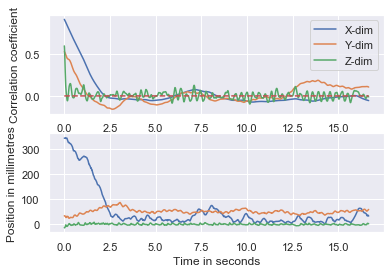

In [163]:
fig15 = plt.figure()
plt.subplot(2,1,1)
plt.plot(time[:len(acf_rax)],acf_rax,label='X-dim')
plt.plot(time[:len(acf_ray)],acf_ray,label='Y-dim')
plt.plot(time[:len(acf_raz)],acf_raz,label='Z-dim')
plt.plot(time[:len(acf_raz)],np.zeros(len(acf_raz)),'r--')
#plt.plot(time[:len(acf_rax)],acf_rax - acf_ray,label='X-Y')
plt.legend()
plt.xlabel('Lag in seconds')
plt.ylabel('Correlation coefficient')
#plt.title("ACF right ankle")

plt.subplot(2,1,2)
plt.plot(time[:l],right_knee_x[:l],label='X-dim')
plt.plot(time[:l],right_knee_y[:l],label='Y-dim')
plt.plot(time[:l],right_knee_z[:l],label='Z-dim')
plt.xlabel('Time in seconds')
plt.ylabel('Position in millimetres')
#plt.title('Position of the right ankle')
plt.show()

In [164]:
#let's do the delay embedding
def delay_matrix(ts,tau,N):
    l = len(ts)
    k = l-(N*tau)
    delay_embed = []
    for i in range(N):
        delay_embed.append(ts[i*tau:k+(i*tau)])
    return np.array(delay_embed)

In [165]:
raz_embed = delay_matrix(right_knee_z[:5000],10,7)

In [166]:
raz_embed_3d = delay_matrix(right_knee_30s_3d,10,7)

In [167]:
np.shape(raz_embed_3d)

(7, 9930, 3)

In [168]:
np.shape(right_knee_30s_3d)

(10000, 3)

In [169]:
10000 - 7*600

5800

In [170]:
def trajectory_matrix_nd(tseries, tau_win, tau_lag=1, T_win=0):
    """This function constructs the trajectory matrix for a given n-dimensional time series"""
 #tau_win is the window size
 #tau_lag is a parameter that can be used to construct a lagged trajectory matrix
 #T_win can be used to pick a certain portion of the timeseries to be used in constructing the trajectory matrix
 # obtaining length and dimension of the time series
 #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
 #preprocessing the timeseries to recast it in the required shape: length,dimension
    if np.shape(tseries)[0]<np.shape(tseries)[1]:
        tseries = np.transpose(tseries)
    else:
        tseries = tseries

        length = np.shape(tseries)[0]
    dimension = np.shape(tseries)[1]

 #choosing the length of the time series we want to use
    if T_win==0:
        tseries = tseries
        chi = int((length-tau_win)/tau_lag)
    else:
        tseries = tseries[:T_win]
        chi = int((T_win-tau_win)/tau_lag)

#defining the trajectory matrix

    eta = np.empty((chi,tau_win*dimension))

    for i in range(dimension):
        for j in range(chi): #iterating over the rows
            eta[j,i*tau_win:i*tau_win+tau_win] = tseries[(j*(tau_lag)):j*(tau_lag)+tau_win, i]

    eta = np.transpose(np.array(eta))
    return eta

In [171]:
raz_traj_3d = trajectory_matrix_nd(right_knee_30s_3d,35)

In [172]:
np.shape(raz_traj_3d)

(105, 9965)

In [173]:
raz_traj_3d[:,0]

array([344.08772431, 344.01685648, 343.9337295 , 343.84373818,
       343.60668197, 343.64787975, 343.68013129, 343.70419522,
       343.74126153, 343.82862087, 343.93099333, 344.05675052,
       344.15647439, 344.26949736, 344.37139805, 344.44847758,
       344.47822569, 344.66218571, 344.70790943, 343.57414925,
       343.56561711, 343.44047418, 343.27756132, 343.34848992,
       342.99996217, 342.68428185, 343.50582449, 343.21288794,
       343.18386962, 343.08632062, 343.13845758, 343.19239953,
       343.38236903, 343.52407278, 343.71778756,  33.97520922,
        34.00521333,  34.07576932,  34.15800309,  34.3613374 ,
        34.38334091,  34.41043274,  34.39632726,  34.28282259,
        34.08994073,  33.82838443,  33.52189133,  33.20965719,
        32.88757634,  32.56558355,  32.29039976,  32.09507588,
        31.84299976,  31.6472379 ,  31.78979662,  31.50567451,
        31.13890834,  30.64617494,  29.7915721 ,  29.18672807,
        28.68104459,  27.83273248,  27.41390973,  27.13

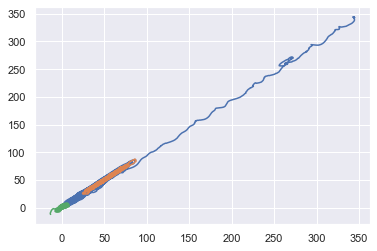

In [174]:
fig30 = plt.figure(30)
plt.plot(raz_embed_3d[0,:],raz_embed_3d[1,:])

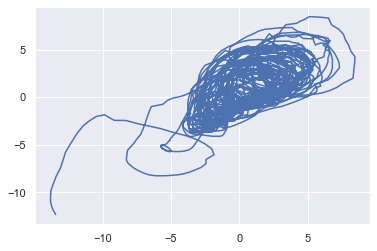

In [175]:
fig16 = plt.figure(16)
plt.plot(raz_embed[0,:],raz_embed[1,:])
plt.show()

In [176]:
#%matplotlib

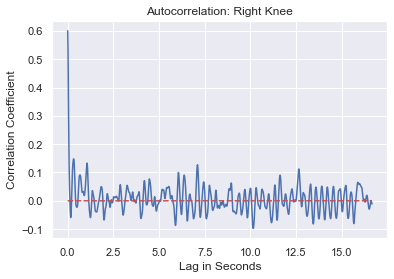

In [177]:
fig17 = plt.figure(17)
plt.plot(time[:len(acf_raz)],acf_raz,label='Z-dim')
plt.plot(time[:len(acf_raz)],np.zeros(len(acf_raz)),'r--')
plt.xlabel('Lag in Seconds')
plt.ylabel('Correlation Coefficient')
plt.title('Autocorrelation: Right Knee')
plt.show()

In [178]:
#%matplotlib

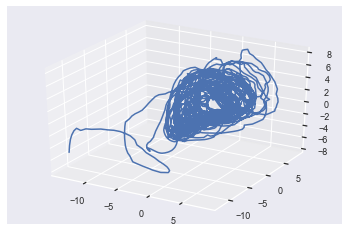

In [179]:
fig18 = plt.figure(18)
ax = plt.axes(projection='3d')

ax.plot3D(raz_embed[0,:],raz_embed[1,:],raz_embed[2,:])
ax.tick_params(labelsize=9)
plt.show()

In [180]:
np.shape(raz_embed_3d)

(7, 9930, 3)

In [181]:
#np.shape(np.cov(np.transpose(raz_embed_3d)))

In [182]:
#let's do ssa on the trajectory matrix better resolution of cycles
def SSA(trajectory_matrix):
    covT = np.cov(np.transpose(trajectory_matrix))
    u,s,v = np.linalg.svd(covT)
    s_norm = s/sum(s)
    #weighting the svecs
    #weighted_svecs = []
    #for i in range(len(s)):
        #weighted_svecs.append(s_norm[i]*v[:,i])
    #weighted_svecs = np.array(weighted_svecs)    
    return s_norm, v

In [183]:
ssa_3d_test_sv, ssa_3d_test_vecs = SSA(raz_traj_3d)

In [184]:
ssa_3d_test_sv

array([6.52795846e-01, 3.44213284e-01, 1.83762245e-03, ...,
       6.50304170e-17, 3.80597710e-17, 2.50343611e-17])

In [185]:
ssa_test_sv, ssa_test_vecs = SSA(raz_embed) 

In [186]:
ssa_test_sv

array([5.21371201e-01, 2.91889550e-01, 1.08680576e-01, ...,
       4.36001580e-17, 2.57456011e-17, 8.06734439e-18])

In [187]:
np.cumsum(ssa_test_sv)

array([0.5213712 , 0.81326075, 0.92194133, ..., 1.        , 1.        ,
       1.        ])

In [188]:
np.shape(ssa_test_vecs)

(4930, 4930)

In [189]:
#now weight the vec

In [190]:
#%matplotlib

In [191]:
from matplotlib.ticker import NullFormatter
#ax2.axes.get_xaxis().set_major_formatter(NullFormatter())

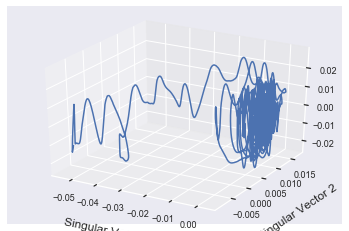

In [192]:
fig31 = plt.figure(31)

ax = plt.axes(projection='3d')

ax.plot3D(ssa_3d_test_vecs[0,:],ssa_3d_test_vecs[1,:],ssa_3d_test_vecs[2,:])
ax.tick_params(labelsize=9)
#ax.axes.get_xaxis().set_major_formatter(NullFormatter())
#ax.axes.get_yaxis().set_major_formatter(NullFormatter())
#ax.axes.get_zaxis().set_major_formatter(NullFormatter())
#ax.set_xticks(['']*len(ssa_3d_test_vecs[0,:]))
#ax.set_yticks(['']*len(ssa_3d_test_vecs[1,:]))
#ax.set_zticks(['']*len(ssa_3d_test_vecs[2,:]))
ax.set_xlabel('Singular Vector 1',labelpad=12)
ax.set_ylabel('Singular Vector 2', labelpad=12)
ax.set_zlabel('Singular Vector 3', labelpad=12)


plt.show()
#plt.savefig('SSA_3d_l.png',transparent=True)

In [193]:
for i in range(len(ssa_3d_test_sv)):
    print(sum(ssa_3d_test_sv[:i+1]))

0.6527958463707371
0.9970091305242712
0.9988467529783479
0.9993917351520509
0.9997212030889105
0.9998181568960849
0.9998988744980344
0.9999357743598548
0.9999585112468538
0.9999699283256217
0.9999768986942251
0.99998268660336
0.9999860941290242
0.9999880971298217
0.9999897300994006
0.9999911284359441
0.999992141967285
0.9999927982267997
0.999993400622742
0.9999939198374397
0.9999943550187427
0.9999947001511506
0.9999950298687593
0.9999953301119711
0.999995596630314
0.9999958404731198
0.9999960668029957
0.9999962615576122
0.99999642675438
0.9999965907632613
0.9999967427163594
0.9999968748609316
0.9999969983893042
0.9999971177175039
0.9999972362245032
0.9999973483126384
0.9999974524472909
0.9999975526094521
0.9999976480451873
0.9999977369309081
0.9999978238787114
0.9999979058467181
0.9999979857017629
0.9999980600620086
0.999998133099546
0.9999982036923409
0.9999982732346485
0.9999983427380716
0.9999984111067514
0.999998479208187
0.9999985471738891
0.9999986142609327
0.9999986810633109
0.

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [194]:
np.shape(ssa_3d_test_sv)

(9965,)

In [195]:
np.arange(1,10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

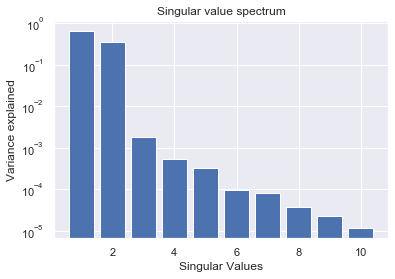

In [196]:
fig32 = plt.figure(32)
plt.bar(np.arange(1,11),ssa_3d_test_sv[:10])
plt.yscale('log')
plt.title('Singular value spectrum')
plt.xlabel('Singular Values')
plt.ylabel('Variance explained')
plt.show()

In [197]:
abs(min(ssa_test_vecs[0,:])-max(ssa_test_vecs[0,:]))

0.07244047146101025

In [198]:
len(ssa_test_vecs[0,:])

4930

In [199]:
(min(ssa_test_vecs[1,:]),max(ssa_test_vecs[1,:]))

(-0.04051591328994316, 0.03461982509610847)

In [200]:
(min(ssa_test_vecs[2,:]),max(ssa_test_vecs[2,:]))

(-0.07371082537035385, 0.0357326530727065)

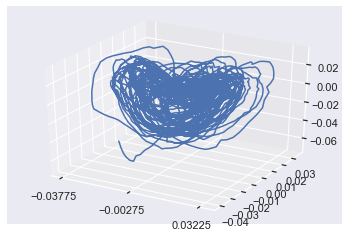

In [201]:
fig19 = plt.figure(19)
ax = plt.axes(projection='3d')

ax.plot3D(ssa_test_vecs[0,:],ssa_test_vecs[1,:],ssa_test_vecs[2,:])
ax.set_xticks(np.arange(min(ssa_test_vecs[0,:]),max(ssa_test_vecs[0,:])+0.0075,0.035))
plt.show()
#plt.savefig('SSA_3d.png',transparent=true)

In [202]:
len(acf_raz)

5000

In [203]:
time_bound = np.tile([np.arange(10)],500)

In [204]:
np.shape(time_bound[0])

(5000,)

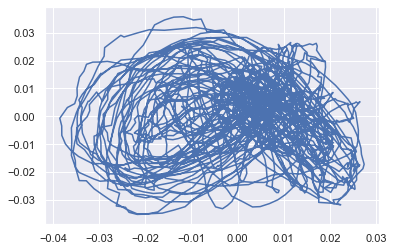

In [205]:
fig20 = plt.figure(20)
plt.plot(ssa_test_vecs[1,500:-500],ssa_test_vecs[2,500:-500])
plt.show()

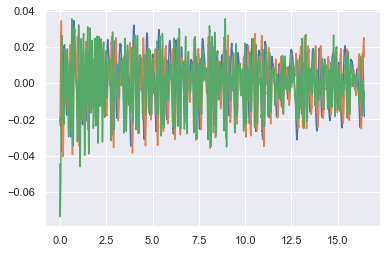

In [206]:
fig21 = plt.figure(21)
plt.plot(time[:len(ssa_test_vecs)],ssa_test_vecs[0,:])
plt.plot(time[:len(ssa_test_vecs)],ssa_test_vecs[1,:])
plt.plot(time[:len(ssa_test_vecs)],ssa_test_vecs[2,:])
plt.show()

## Recurrence analysis?

In [207]:
def recur_plot(timeseries,epsilon):
    a,b = np.shape(timeseries)
    if a>b:
        l = a
        timeseries = np.transpose(timeseries)
    else:
        l = b
        timeseries = timeseries
    print(l)
    distance_matrix = np.zeros((l,l))
    recurrence_matrix = np.zeros((l,l))
    print(np.shape(distance_matrix))
    for i in range(l):
        if i%100==0:
            print(i)
        for j in range(l):
            dist = abs(np.linalg.norm(timeseries[:,i] - timeseries[:,j]))
            distance_matrix[i,j] = dist
        #normalising distance
    distance_matrix = distance_matrix/max(np.reshape(distance_matrix,l*l)) 
    
    for i in range(l):
        for j in range(l):
            if distance_matrix[i,j]<=epsilon:
                recurrence_matrix[i,j] = 1
            else:
                recurrence_matrix[i,j] = 0
    return distance_matrix, recurrence_matrix
            

In [208]:
len(ssa_test_vecs)

4930

In [209]:
#Let's make two subfunctions, one that computes the distance matrix and another that computes the recurrence plot
def distance_matrix(timeseries):
    if np.ndim(timeseries) >1:
        a,b = np.shape(timeseries)
        if a>b:
            l = a
            timeseries = np.transpose(timeseries)
        else:
            l = b
            timeseries = timeseries
        print(l)
    elif np.ndim(timeseries) == 0:
        raise ValueError("I need a non-zero dimensional timeseries to proceed!")
    else:
        l = len(timeseries)
    distance_matrix = np.zeros((l,l))
    recurrence_matrix = np.zeros((l,l))
    print(np.shape(distance_matrix))
    if np.ndim(timeseries) > 1:
        for i in range(l):
            if i%1000==0:
                print(i)
            for j in range(l):
                dist = abs(np.linalg.norm(timeseries[:,i] - timeseries[:,j]))
                distance_matrix[i,j] = dist
        #normalising distance
    else:
        for i in range(l):
            if i%500==0:
                print(i)
            for j in range(l):
                dist = abs(np.linalg.norm(timeseries[i] - timeseries[j]))
                distance_matrix[i,j] = dist 
                
                
    max_dist = max(np.reshape(distance_matrix,l*l))
    print(max_dist)
    distance_matrix = distance_matrix/max_dist
    return distance_matrix, max_dist
    

In [210]:
def recurrence_matrix(dist_matrix,epsilon):
    l = len(dist_matrix)
    recur_matrix = np.zeros((l,l))
    for i in range(l):
        for j in range(l):
            if dist_matrix[i,j]<=epsilon:
                recur_matrix[i,j] = 1
            else:
                recur_matrix[i,j] = 0
    return recur_matrix
            
    

In [211]:
np.shape(ssa_3d_test_vecs)

(9965, 9965)

In [212]:
ssa_dist=distance_matrix(ssa_3d_test_vecs[:3,:])

9965
(9965, 9965)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0.07002836490718334


In [291]:
ssa_recur = recurrence_matrix(ssa_dist[0],0.03)

In [292]:
%matplotlib

Using matplotlib backend: MacOSX


In [293]:
fig33 = plt.figure(33)

plt.imshow(ssa_dist[0])
plt.colorbar()

plt.show()

In [294]:
fig34 = plt.figure(34)

plt.imshow(ssa_recur)
plt.colorbar()

plt.show()

In [276]:
np.shape(right_knee_30s_3d)

(10000, 3)

In [278]:
fig42 = plt.figure(42)

plt.plot(right_knee_30s_3d[:,2])

plt.show()

In [290]:
ssa_dist[1]

0.07002836490718334

In [289]:
fig43 = plt.figure(43)

ax = plt.axes(projection='3d')

#ax.plot3D(right_knee_30s_3d[2500:3000,0],right_knee_30s_3d[2500:3000,1],right_knee_30s_3d[2500:3000,2])
#ax.plot3D(right_knee_30s_3d[2500:2600,0],right_knee_30s_3d[2500:2600,1],right_knee_30s_3d[2500:2600,2])
#ax.plot3D(ssa_test_vecs[0,2500:3000],ssa_test_vecs[1,2500:3000],ssa_test_vecs[2,2500:3000])
ax.scatter(ssa_test_vecs[0,2500:2650],ssa_test_vecs[1,2500:2650],ssa_test_vecs[2,2500:2650])
plt.show()

# # Cycle period

In [219]:
a = 0
a=+1

In [220]:
a

1

Let's also have a test set, a sinewave, easy and nice

In [221]:
import math

In [222]:
test_x = np.linspace(0,100,10000)
test_y = np.sin(test_x)


In [223]:
# A code to obtain distribution of given cycle periods for a given recurrence matrix at a given epsilon
def recurrence_period(r_matrix):
    l = len(r_matrix)
    period = []
    non_zero = []
    for i in range(l):
        for j in range(l):
            if r_matrix[i,j] != 0:
                if i!=j:
                    period.append(abs(i-j))
                    non_zero.append(1)
    return period, sum(non_zero)

In [224]:
ssa_period = recurrence_period(ssa_recur)

In [225]:
ssa_period[0]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 2,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 3,
 2,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 4,
 3,
 2,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 5,
 4,
 3,
 2,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 6,
 5,
 4,
 3,
 2,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 10,
 9,
 8,
 7,
 6,
 5

In [227]:
hist_p, bins_p = np.histogram(ssa_period[0])

In [228]:
fig35 = plt.figure(35)

plt.hist(ssa_period[0])

plt.show()

In [229]:
#let's try the same for the non-embedded cycles to see what happens

In [230]:
unembedded_dist, unembedded_max_dist = distance_matrix(right_knee_30s_3d)

10000
(10000, 10000)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
345.24063980037386


In [231]:
unembedded_dist

array([[0.00000000e+00, 5.34389575e-04, 1.00913685e-03, ...,
        9.83422073e-01, 9.84278368e-01, 9.84878617e-01],
       [5.34389575e-04, 0.00000000e+00, 4.87510842e-04, ...,
        9.83231390e-01, 9.84088298e-01, 9.84689216e-01],
       [1.00913685e-03, 4.87510842e-04, 0.00000000e+00, ...,
        9.82993899e-01, 9.83851314e-01, 9.84452766e-01],
       ...,
       [9.83422073e-01, 9.83231390e-01, 9.82993899e-01, ...,
        0.00000000e+00, 1.48246203e-03, 2.91739431e-03],
       [9.84278368e-01, 9.84088298e-01, 9.83851314e-01, ...,
        1.48246203e-03, 0.00000000e+00, 1.45182554e-03],
       [9.84878617e-01, 9.84689216e-01, 9.84452766e-01, ...,
        2.91739431e-03, 1.45182554e-03, 0.00000000e+00]])

In [232]:
fig36 = plt.figure(36)

plt.imshow(unembedded_dist)

plt.colorbar()

plt.show()

In [233]:
distance_matrix_4d, max_dist_4d = distance_matrix(ssa_3d_test_vecs[:4,:])

9965
(9965, 9965)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0.07467200416628521


In [234]:
fig37 = plt.figure(37)

plt.imshow(distance_matrix_4d)
plt.colorbar()

plt.show()

In [236]:
distance_matrix_5d, max_dist_5d = distance_matrix(ssa_3d_test_vecs[:5,:])

9965
(9965, 9965)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0.0947599141961567


In [251]:
np.shape(distance_matrix)

()

In [308]:
red_recurrence = ssa_recur[::6,::6]

In [309]:
np.shape(red_recurrence)

(1661, 1661)

In [311]:
fig41 = plt.figure(41)

plt.imshow(red_recurrence)
plt.colorbar()

plt.show()

In [237]:
fig38 = plt.figure(38)

plt.imshow(distance_matrix_5d)
plt.colorbar()

plt.show()

In [238]:
sine_dist = distance_matrix(test_y)


(10000, 10000)
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
1.9999997946451493


In [239]:
sine_dist[0]

array([[0.        , 0.00500042, 0.01000033, ..., 0.26175568, 0.25748214,
        0.25318285],
       [0.00500042, 0.        , 0.00499992, ..., 0.2667561 , 0.26248256,
        0.25818326],
       [0.01000033, 0.00499992, 0.        , ..., 0.27175601, 0.26748247,
        0.26318318],
       ...,
       [0.26175568, 0.2667561 , 0.27175601, ..., 0.        , 0.00427354,
        0.00857283],
       [0.25748214, 0.26248256, 0.26748247, ..., 0.00427354, 0.        ,
        0.00429929],
       [0.25318285, 0.25818326, 0.26318318, ..., 0.00857283, 0.00429929,
        0.        ]])

In [240]:
fig39 = plt.figure(39)

plt.imshow(sine_dist[0])

plt.colorbar()
plt.show()

In [248]:
unembedded_recurrence = recurrence_matrix(unembedded_dist,0.01)

In [249]:
fig40 = plt.figure(40)
plt.imshow(unembedded_recurrence)

plt.colorbar()
plt.show()

In [247]:
unembedded_max_dist*5/100

17.26203199001869

In [241]:
#let's see at what dimension the parwise mutual oinfo peaks out...a measure of the embedding dimension I guess'

## Pairwise mutual information

The Idea is to compute the distance matrix at each embedding dimension and see how much more information one gains by looking at distances between two points. I can do measure for all the points.... i.e how significantly does the measure of the system change as I increase the embedding dimension.

How do I do this:
0. I already have the distane matrix calculations, or a function to do that 
1. I start by computing the probability distributiosn for each n-dim embedding.
2. Then I compute the joint probability distribution for n, and n+1-dim embedding that I am comparing
3. I then compute the mutual information for this comparison. Once this is done I do it again for n+1-dim and n+2-dim and see if i obtain some sort of plateu, where the slop is significantly zero.


The formula for mutual information that I will use:<br>  $ I(x,y) = H(x) + H(y) - H(x,y) $


Where the formula for entropy is given by:<br>
    $H(r) = -\sum{p(r)_{i}\ln{p(r)_{i}}}$

In [242]:
np.ndim(distance_matrix_5d)

2

In [ ]:
def probability_distr(data_array,):
    """A function to compute teh proabbility distribution of a given """
    #first we make sure the array is one dimensional
    l = len(array)
    dim = np.ndim(data_array)
    if dim==1:
        print("All good the array is 1d")
        array=data_array
    elif dim==2:
        print("Looks like we have a distance matrix? Let's squeeze that down to a 1D array!")
        array=np.reshape(data_array,l*l)
    else:
        print("I am out of my depth here.... need to give me a lower dimensional array")
        raise ValueError(str("Input array needs to 1 or 2 dimesnional, the given array is "+ dim +"dimensional"))
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    #now we just compute teh probability distribution
    hist_array, bins_array = np.histogram(array)
    
    return hist_array, bins_array

        